In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from collections import Counter
from operator import itemgetter

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

DATA_PATH = './data'
SELECT_YEAR = 2017

### Data Read

In [2]:

data_file = '{}/{}lattesPre.txt'.format(DATA_PATH, SELECT_YEAR)
col_names=['docs'] 
df = pd.read_csv(data_file, header=None, names=col_names)
print('{} docs shape'.format(df.shape))

(3055, 1) docs shape


In [3]:
df['w_count'] = df['docs'].str.split().str.len()
df['w_count'].describe()

count    3055.000000
mean       25.455319
std        28.096205
min         1.000000
25%         9.000000
50%        16.000000
75%        31.000000
max       384.000000
Name: w_count, dtype: float64

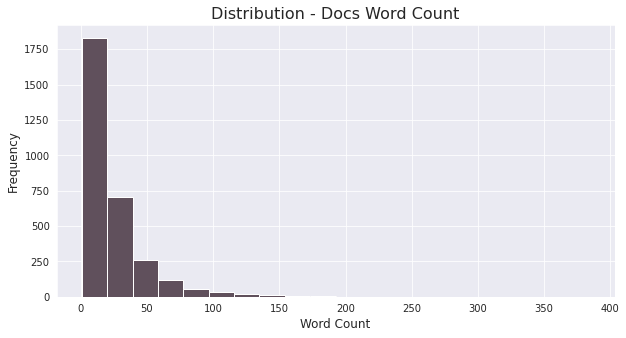

In [4]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df['w_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Docs Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.show()

In [5]:
p_text = df['docs'].apply(word_tokenize)
p_text = [item for sublist in p_text for item in sublist]

top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,base,1198
1,use,1131
2,model,853
3,system,806
4,network,762
5,analysi,704
6,data,591
7,approach,522
8,studi,471
9,learn,437


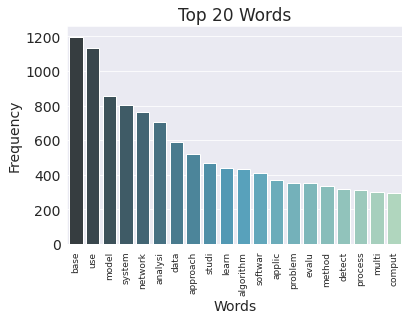

In [6]:
g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=9
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [7]:
num_unique_words = len(set(p_text))
num_unique_words

9037

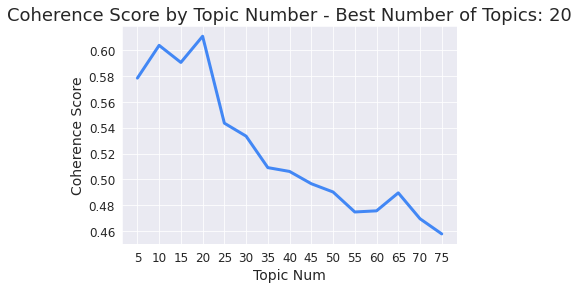

In [8]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['docs'].apply(word_tokenize)

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### TF-IDF

In [9]:
docs = df['docs']

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=.005, max_df=.85, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_fn = tfidf_vectorizer.get_feature_names()

print('vocabulary: {}'.format(len(tfidf_vectorizer.vocabulary_)))
print('sparse matrix shape: {}'.format(tfidf.shape))
print('nonzero count: {}'.format(tfidf.nnz))
print('sparsity: {:.3f}'.format(100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



vocabulary: 852
sparse matrix shape: (3055, 852)
nonzero count: 44165
sparsity: 1.697


,term,weight
66,base,0.036343
819,use,0.035731
488,model,0.031914
512,network,0.028672
34,analysi,0.026310
194,data,0.024125
43,approach,0.021474
748,studi,0.019563
27,algorithm,0.019221
423,learn,0.018863


## NMF

In [10]:
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

idx_to_word = np.array(tfidf_fn)
for i, topic in enumerate(nmf.components_):
    print('Topic {}: {}'.format(i + 1, ','.join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: classif,improv,estim,measur,3d,predict,evalu,techniqu,method,use
Topic 2: literatur review,game,engin,softwar develop,literatur,project,review,systemat,develop,softwar
Topic 3: multi object,search,object,heurist,multi,genet algorithm,genet,optim,algorithm,problem
Topic 4: secur,environ,applic,mobil,evalu,cloud comput,perform,servic,comput,cloud
Topic 5: interact,conceptu,driven,ontolog,paramet,estim,base model,model base,simul,model
Topic 6: deep,teach,machin learn,object,machin,learn environ,virtual,environ,educ,learn
Topic 7: scientif,framework,big data,data stream,big,stream,manag,visual,open,data
Topic 8: improv,base approach,featur,method,agent base,select,multi,agent,approach,base
Topic 9: deep,recognit,classif,artifici neural,convolut neural,artifici,convolut,network,neural network,neural
Topic 10: free,threshold,attribut,larg,number,complex,color,path,edg,graph
Topic 11: social network,measur,complex,social,interact,reveal,network analysi,gene,genom,analysi
Topic 12: u

In [11]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

display_topics(nmf,tfidf_fn,10)


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 15 words,Topic 15 weights,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights
0,use,4.338,softwar,1.229,problem,1.332,cloud,1.189,model,2.139,...,network,1.490,test,1.861,brazil,1.582,imag,1.434,control,1.593
1,method,0.660,develop,1.043,algorithm,1.055,comput,0.945,simul,0.519,...,sensor,0.920,softwar test,0.301,structur,0.706,detect,1.168,design,0.465
2,techniqu,0.554,systemat,0.629,optim,0.437,servic,0.543,model base,0.185,...,wireless,0.905,experiment,0.232,effect,0.376,segment,0.520,optim,0.287
3,evalu,0.515,review,0.598,genet,0.427,perform,0.506,base model,0.147,...,sensor network,0.755,impact,0.187,water,0.323,automat,0.366,robot,0.283
4,predict,0.413,project,0.456,genet algorithm,0.379,cloud comput,0.490,estim,0.144,...,wireless sensor,0.754,program,0.164,brazilian,0.287,classif,0.338,power,0.204
5,3d,0.395,literatur,0.428,multi,0.374,evalu,0.457,paramet,0.120,...,rout,0.206,valid,0.153,assess,0.238,recognit,0.278,autonom,0.192
6,measur,0.365,softwar develop,0.422,heurist,0.321,mobil,0.457,ontolog,0.118,...,manag,0.202,check,0.150,chang,0.231,featur,0.260,low,0.189
7,estim,0.360,engin,0.407,object,0.259,applic,0.395,driven,0.113,...,defin,0.157,assess,0.150,new,0.215,textur,0.234,robust,0.187
8,improv,0.328,game,0.327,search,0.228,environ,0.377,conceptu,0.109,...,power,0.151,code,0.147,state,0.201,method,0.224,vehicl,0.172
9,classif,0.298,literatur review,0.324,multi object,0.227,secur,0.317,interact,0.108,...,network use,0.143,requir,0.140,plant,0.199,deep,0.207,implement,0.144


In [12]:
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

docweights = nmf.transform(tfidf_vectorizer.transform(docs))

n_top_words = 8
topic_df = topic_table(nmf, tfidf_fn, n_top_words).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(word_tokenize) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()


,0,1,2,3,4,5,6,7,topics
0,use,method,techniqu,evalu,predict,3d,measur,estim,use method techniqu evalu predict 3d measur estim
1,softwar,develop,systemat,review,project,literatur,softwar develop,engin,softwar develop systemat review project litera...
2,problem,algorithm,optim,genet,genet algorithm,multi,heurist,object,problem algorithm optim genet multi heurist ob...
3,cloud,comput,servic,perform,cloud comput,evalu,mobil,applic,cloud comput servic perform evalu mobil applic
4,model,simul,model base,base model,estim,paramet,ontolog,driven,model simul base estim paramet ontolog driven


In [13]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

,topic_num,topics
0,0,use method techniqu evalu predict 3d measur estim
1,1,softwar develop systemat review project litera...
2,2,problem algorithm optim genet multi heurist ob...
3,3,cloud comput servic perform evalu mobil applic
4,4,model simul base estim paramet ontolog driven


In [14]:
docs = df['docs'].tolist()

df_temp = pd.DataFrame({
    'docs': docs,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='docs',
    how='left'
)

df_topics


,docs,w_count,topic_num,topics
0,exploit photo locat direct cluster base point ...,23,6,data open visual manag stream big
1,gene express analysi musa acuminata compat int...,16,10,analysi genom gene network reveal interact soc...
2,studi equival electr circuit fit electrochem i...,10,11,studi case brazilian code sustain compar tool
3,dynam connect vessel runaway reaction rigor ev...,46,4,model simul base estim paramet ontolog driven
4,ybs heurist rout spectrum alloc flexibl optic ...,27,8,neural network convolut artifici classif
...,...,...,...,...
3232,retriev 2d shape similar base bag salienc point,8,7,base approach agent multi select method featur
3233,spatiotempor data represent postgi toward spat...,25,6,data open visual manag stream big
3234,interact tool synthesi conson timbr base disso...,25,4,model simul base estim paramet ontolog driven
3235,sentenc day engag student daili write task,7,5,learn educ environ virtual machin object


In [15]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(docs)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 3055 x 852
W = 20 x 852
H = 3055 x 20


In [16]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 2929.434'

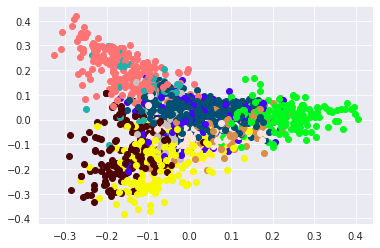

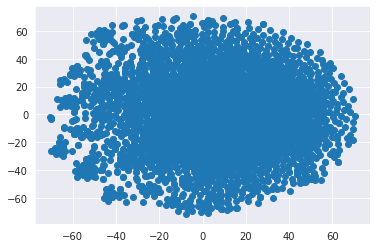

In [17]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(tfidf)
#print(labels)

X = tfidf.todense()

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
#print(reduced_data)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    #print(instance, index, labels[index])
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()